# Visualização de Clusters Fuzzy
Adaptação do código para plotar clusters fuzzy usando dados de throughput e utilização de PRB

In [ ]:
#teste
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [45]:
# Carregar o dataset
file_path = "data/df_agrupamentofuzzy_3.csv"
df = pd.read_csv(file_path)

# Verificar as primeiras linhas
print(df.head())
print(f"\nShape do dataset: {df.shape}")
print(f"\nColunas disponíveis: {list(df.columns)}")

               Data        Grupo Detentora  Vendor     eNodeB            Cell  \
0  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-A   
1  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-B   
2  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-C   
3  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-26-A   
4  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-26-B   

   TIM_PRB_AVAIL (Unid)  TIM_PRB_UTIL_MEAN_DL (%)  \
0                  50.0                     4.544   
1                  50.0                     5.398   
2                  50.0                     4.316   
3                 100.0                     0.935   
4                 100.0                     0.892   

   TIM_PRB_UTIL_MEAN_DL_DEN (Unid)  TIM_PRB_UTIL_MEAN_DL_NUM (Unid)  ...  \
0                             50.0                            227.2  ...   
1                             50.0        

In [46]:
# Definir as variáveis x e y
x_col = 'TIM_THROU_USER_PDCP_DL (Kbps)'
y_col = 'TIM_PRB_UTIL_MEAN_DL (%)'
cluster_col = 'cluster_fuzzy'

# Obter a variável 'set' a partir do one-hot encoding
set_columns = [col for col in df.columns if col.startswith('SET_NUMBER_')]
print(f"Colunas SET encontradas: {set_columns}")

# Criar a variável 'set' a partir do one-hot encoding
df['set'] = df[set_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)

print(f"\nValores únicos de 'set': {sorted(df['set'].unique())}")
print(f"Valores únicos de 'cluster_fuzzy': {sorted(df[cluster_col].unique())}")

Colunas SET encontradas: ['SET_NUMBER_0', 'SET_NUMBER_1', 'SET_NUMBER_2', 'SET_NUMBER_3']

Valores únicos de 'set': [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Valores únicos de 'cluster_fuzzy': [np.int64(0), np.int64(1), np.int64(2)]


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PUC\AppData\Local\Temp\ipykernel_6520\1308015052.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['set'] = df[set_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)


In [47]:
cluster_col = "cluster_fuzzy"

# Contar número de pessoas em cada cluster
cluster_counts = df[cluster_col].value_counts().sort_index()  # ordena por cluster
print("Número de pessoas em cada cluster:")
print(cluster_counts)

Número de pessoas em cada cluster:
cluster_fuzzy
0    9293
1    4359
2    6520
Name: count, dtype: int64


In [48]:
# Estatísticas por cluster
print("Estatísticas por cluster:")
for cluster in clusters:
    subset = df[df[cluster_col] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Quantidade de pontos: {len(subset)}")
    print(f"  Throughput médio: {subset[x_col].mean():.2f} Kbps")
    print(f"  Utilização PRB média: {subset[y_col].mean():.2f}%")
    print(f"  SETs presentes: {sorted(subset['set'].unique())}")

Estatísticas por cluster:

Cluster 0:
  Quantidade de pontos: 9293
  Throughput médio: 19804.54 Kbps
  Utilização PRB média: 14.91%
  SETs presentes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Cluster 1:
  Quantidade de pontos: 4359
  Throughput médio: 17220.12 Kbps
  Utilização PRB média: 63.45%
  SETs presentes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Cluster 2:
  Quantidade de pontos: 6520
  Throughput médio: 33587.86 Kbps
  Utilização PRB média: 11.60%
  SETs presentes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Cluster 3:
  Quantidade de pontos: 0
  Throughput médio: nan Kbps
  Utilização PRB média: nan%
  SETs presentes: []

Cluster 4:
  Quantidade de pontos: 0
  Throughput médio: nan Kbps
  Utilização PRB média: nan%
  SETs presentes: []


<Figure size 1000x600 with 0 Axes>

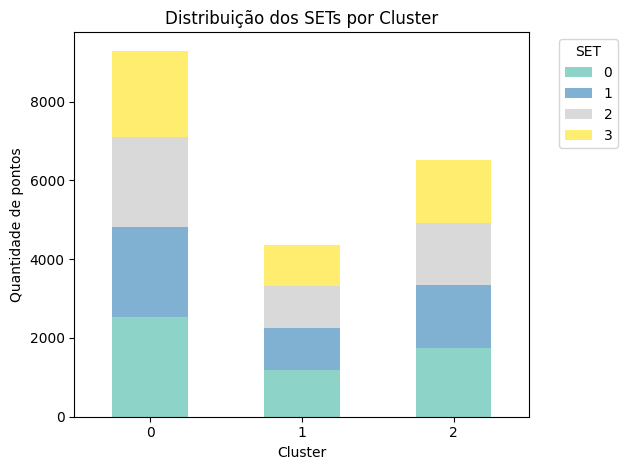

In [49]:
# Gráfico adicional: distribuição dos SETs por cluster
plt.figure(figsize=(10, 6))

set_cluster_counts = df.groupby([cluster_col, 'set']).size().unstack(fill_value=0)
set_cluster_counts.plot(kind='bar', stacked=True, colormap='Set3')

plt.title('Distribuição dos SETs por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de pontos')
plt.legend(title='SET', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()